In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import splitfolders

# Path to your dataset in Google Drive
dataset_path = "/content/drive/MyDrive/DataSet/data"

# Splitting dataset into train, val, and test (70%, 20%, 10%)
splitfolders.ratio(dataset_path,
                   output="/content/drive/MyDrive/DataSet",
                   seed=42,
                   ratio=(.7, .2, .1),
                   group_prefix=None,
                   move=False)

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns



In [4]:
# Basic configurations
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 30  # Adjust epochs for better training
n_classes = 4


In [5]:
# Load train, validation, and test datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSet/Corn/train",  # Update path to the correct directory
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSet/Corn/val",  # Update path
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSet/Corn/test",  # Update path
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2930 files belonging to 4 classes.
Found 836 files belonging to 4 classes.
Found 422 files belonging to 4 classes.


In [6]:
# Optimize data loading with prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [7]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01).numpy())

lr_schedule = LearningRateScheduler(scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
# Data augmentation
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),  # Contrast augmentation
])

In [9]:
# Load pre-trained VGG19 and InceptionV3 models
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
for layer in vgg19_model.layers[-15:]:
    layer.trainable = True

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
for layer in inception_model.layers[-25:]:
    layer.trainable = True

# Model input
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Preprocessing and augmentation
x = resize_and_rescale(input_layer)
x = data_augmentation(x)

# Get outputs from VGG19 and InceptionV3
vgg19_output = vgg19_model(x)
inception_output = inception_model(x)

# Apply Global Average Pooling
vgg19_output = layers.GlobalAveragePooling2D()(vgg19_output)
inception_output = layers.GlobalAveragePooling2D()(inception_output)

# Concatenate outputs from both models
concatenated = layers.Concatenate()([vgg19_output, inception_output])

# Add dense layers with regularization
dense1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concatenated)
dropout1 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout1)
dropout2 = layers.Dropout(0.5)(dense2)

# Output layer
output_layer = layers.Dense(n_classes, activation='softmax')(dropout2)

# Create the final model
model = models.Model(inputs=input_layer, outputs=output_layer)

In [10]:
# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 128, 128, 3)    │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 4, 4, 512)      │     20,024,384 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 2, 2, 2048)     │     21,802,784 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2560)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,311,232 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │          1,028 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,270,756 (165.06 MB)

 Trainable params: 43,236,324 (164.93 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [11]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[lr_schedule, early_stopping]
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.4395 - loss: 2.4413 - val_accuracy: 0.7931 - val_loss: 1.6462 - learning_rate: 1.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.7856 - loss: 1.6572 - val_accuracy: 0.8756 - val_loss: 1.4012 - learning_rate: 1.0000e-04
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8382 - loss: 1.4717 - val_accuracy: 0.9043 - val_loss: 1.2905 - learning_rate: 1.0000e-04
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.8627 - loss: 1.3681 - val_accuracy: 0.9151 - val_loss: 1.2221 - learning_rate: 1.0000e-04
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.8869 - loss: 1.2821 - val_accuracy: 0.9330 - val_loss: 1.1694 - learning_rate: 1.0000e-04
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9108 - loss: 1.2091 - val_accuracy: 0.9402 - val_loss: 1.1496 - learning_rate: 9.9005e-05
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accur

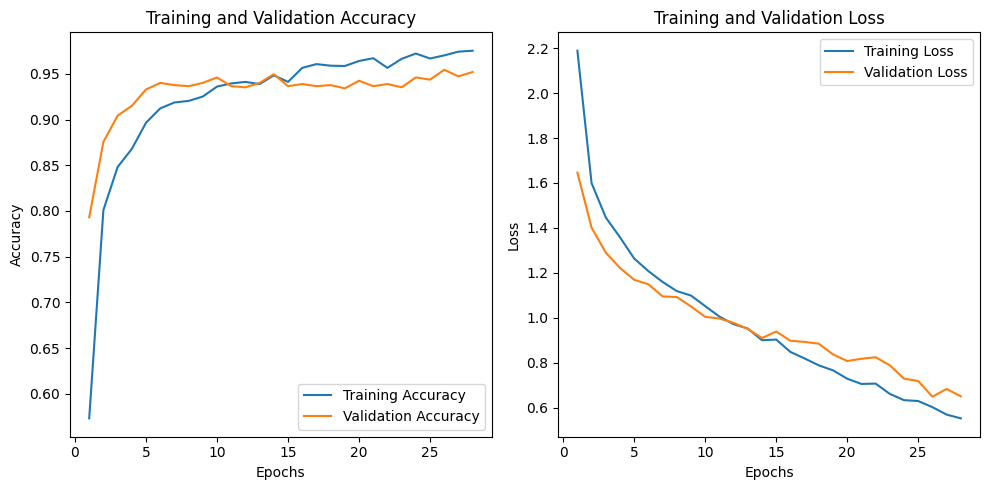

In [13]:
acc = history.history['accuracy'][:28]
val_acc = history.history['val_accuracy'][:28]
loss = history.history['loss'][:28]
val_loss = history.history['val_loss'][:28]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot position 1
plt.plot(range(1, 29), acc, label='Training Accuracy')
plt.plot(range(1, 29), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot position 2
plt.plot(range(1, 29), loss, label='Training Loss')
plt.plot(range(1, 29), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.savefig('training_plot.png')

plt.tight_layout()  # To adjust the spacing between subplots
plt.show()


In [14]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 206ms/step - accuracy: 0.9452 - loss: 0.6508
Test accuracy: 0.9526


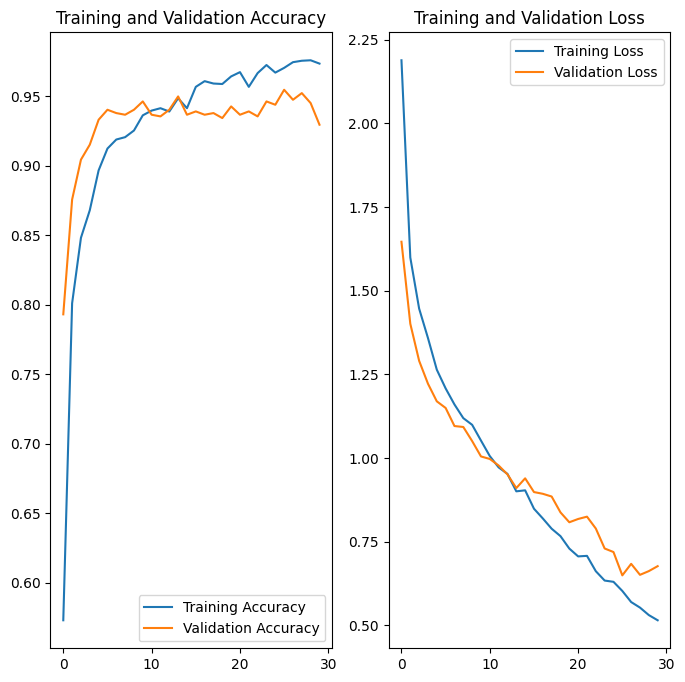

In [15]:
# Plot training and validation curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Get the true labels and predicted probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convert predicted probabilities to predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


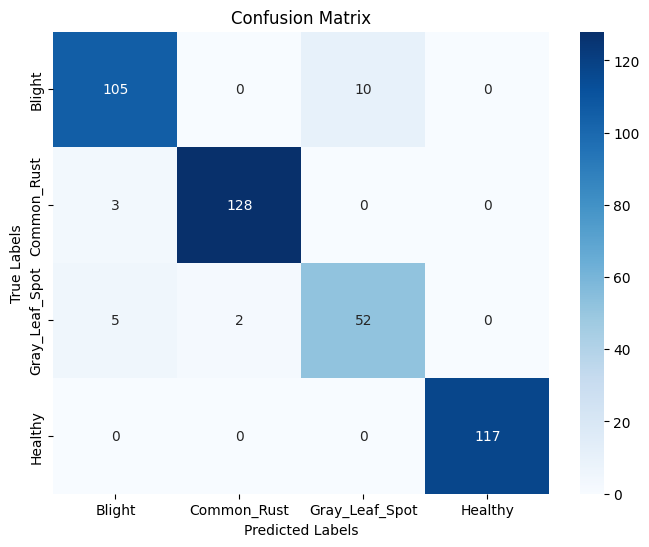

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], yticklabels=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Classification report
class_report = classification_report(y_true, y_pred, target_names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'])
print("Classification Report:")
print(class_report)

Classification Report:
                precision    recall  f1-score   support

        Blight       0.93      0.91      0.92       115
   Common_Rust       0.98      0.98      0.98       131
Gray_Leaf_Spot       0.84      0.88      0.86        59
       Healthy       1.00      1.00      1.00       117

      accuracy                           0.95       422
     macro avg       0.94      0.94      0.94       422
  weighted avg       0.95      0.95      0.95       422



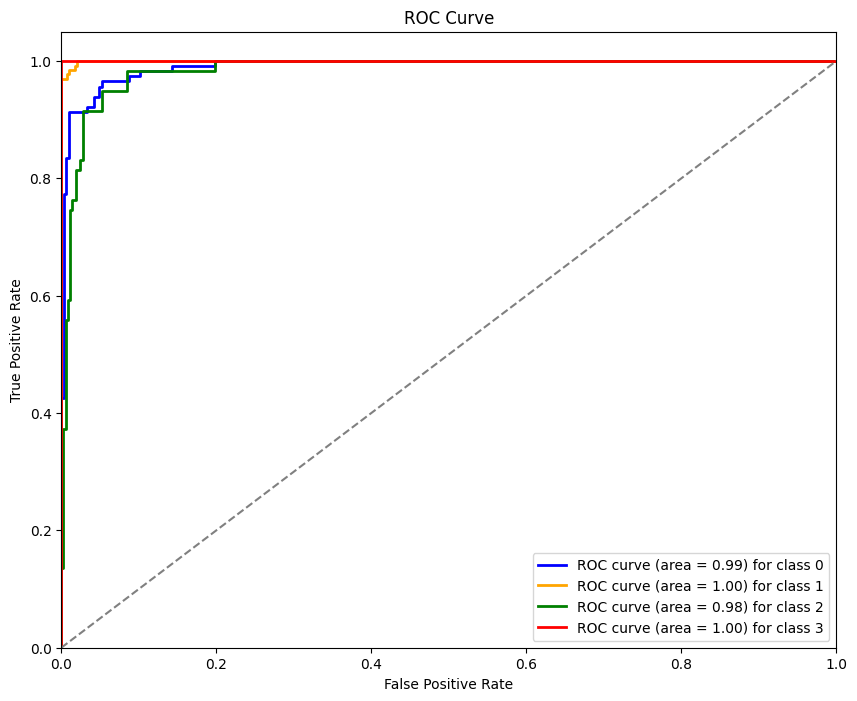

In [19]:
# One-hot encode the true labels for ROC curve
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9604 - loss: 0.6581


[0.6390754580497742, 0.9526066184043884]

In [21]:
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSet/Corn",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 3 classes.


first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted label: Gray_Leaf_Spot


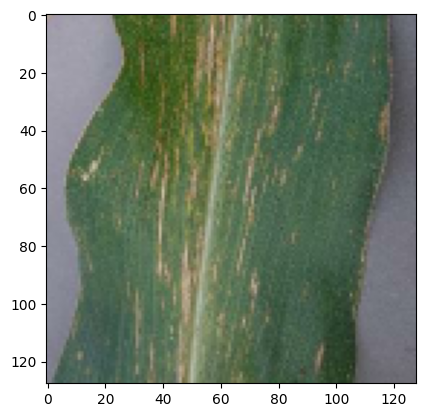

In [25]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)

first image to predict
actual label: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predicted label: Gray_Leaf_Spot


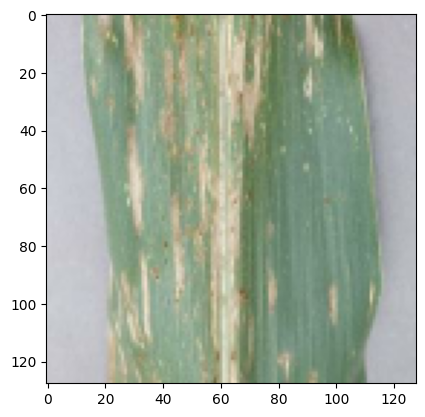

In [26]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predicted label 1: Blight
predicted label 2: Common_Rust
predicted label 3: Blight
predicted label 4: Gray_Leaf_Spot
predicted label 5: Blight
predicted label 6: Blight
predicted label 7: Healthy
predicted label 8: Blight
predicted label 9: Common_Rust
predicted label 10: Common_Rust
predicted label 11: Healthy
predicted label 12: Healthy
predicted label 13: Healthy
predicted label 14: Healthy
predicted label 15: Blight
predicted label 16: Common_Rust
predicted label 17: Healthy
predicted label 18: Common_Rust
predicted label 19: Common_Rust
predicted label 20: Healthy
predicted label 21: Blight
predicted label 22: Gray_Leaf_Spot
predicted label 23: Blight
predicted label 24: Common_Rust
predicted label 25: Common_Rust
predicted label 26: Gray_Leaf_Spot
predicted label 27: Blight
predicted label 28: Healthy
predicted label 29: Blight
predicted label 30: Healthy
predicted label 31: Blight
predicted label 3

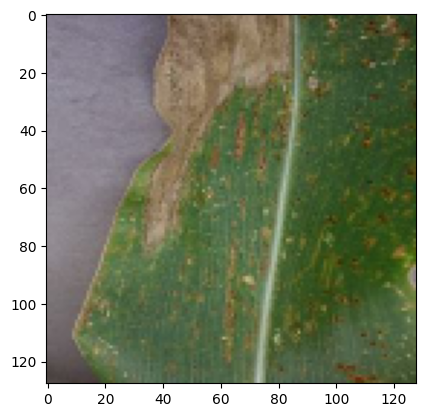

In [27]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the actual label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the predicted labels are within the valid range
    y_pred_indices = np.argmax(batch_prediction, axis=1)
    for i in range(len(y_pred_indices)):
        if 0 <= y_pred_indices[i] < len(class_names):
            print(f"predicted label {i + 1}:", class_names[y_pred_indices[i]])
        else:
            print(f"Invalid predicted index {i + 1}:", y_pred_indices[i])


In [30]:
import pandas as pd

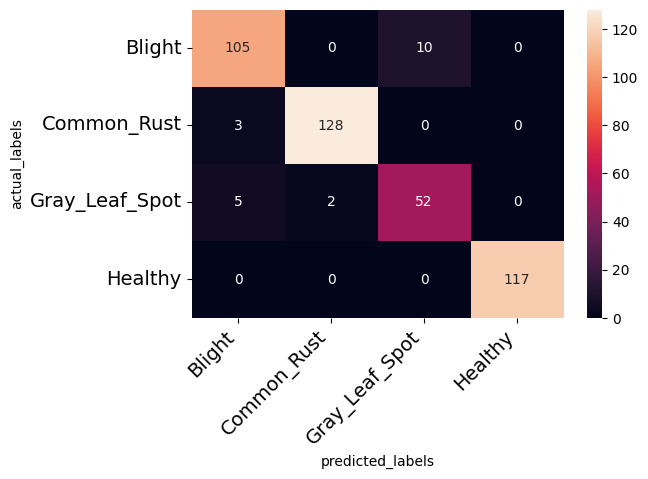

In [31]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('actual_labels')
    plt.xlabel('predicted_labels')
    plt.savefig('confusion.png')

cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm,['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'])

first image to predict
actual label: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
predicted label: Common_Rust


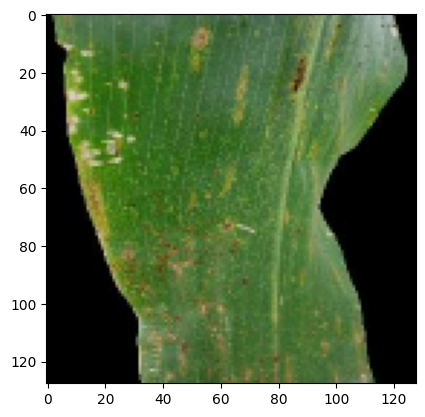

In [32]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted label: Common_Rust


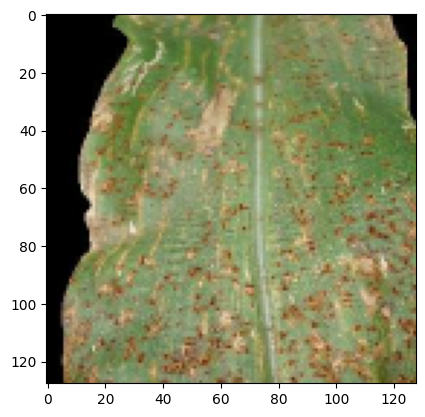

In [33]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
predicted label: Healthy


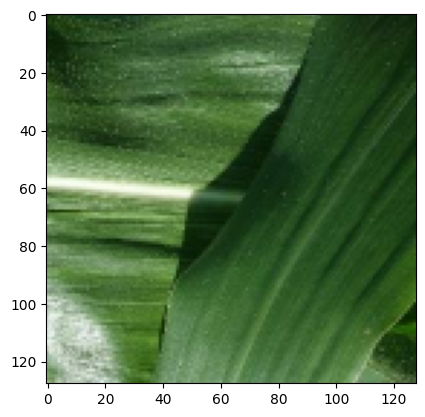

In [34]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
predicted label: Common_Rust


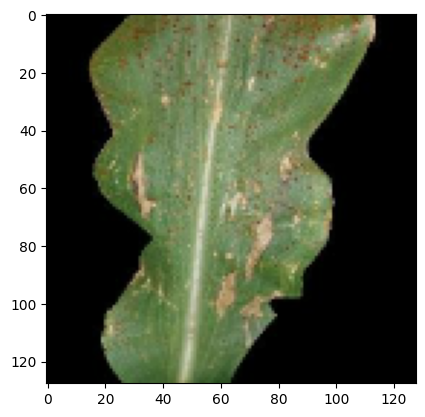

In [35]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)